In [271]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

videos = list(Path("../data/videos").glob("*.mp4"))

0it [00:00, ?it/s]

6302it [00:08, 720.60it/s]


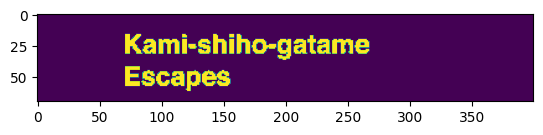

In [392]:
from tqdm import tqdm


def get_frames(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame


def get_subset(img):
    img = img[630:700, :400]
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blur the image
    # img = cv2.GaussianBlur(img, (5, 5), 0)

    # lets binarize based on closeness to white
    t = 255 * 0.9
    img = cv2.inRange(img, (t, t, t), (255, 255, 255), img)
    img = cv2.bitwise_not(img)

    # img = cv2.threshold(img, 255 * 0.7, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # lets also flood fill the background with white
    # start with the 4 corners
    n = img.shape[0]
    cv2.floodFill(img, None, (0, 0), 0)
    cv2.floodFill(img, None, (0, n - 1), 0)
    cv2.floodFill(img, None, (n - 1, 0), 0)
    cv2.floodFill(img, None, (n - 1, n - 1), 0)

    # then 10 random points on the right and top
    # for _ in range(10):
    #     cv2.floodFill(img, None, (0, np.random.randint(0, n)), 255)
    #     cv2.floodFill(img, None, (np.random.randint(0, n), 0), 255)

    # truncate again
    # img = img[30:80, :400]

    # # find the contours from the thresholded image
    # contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # # sort the contours by area
    # contours = sorted(contours, key=cv2.contourArea, reverse=True)
    # # get the largest contour
    # if not contours:
    #     return img
    # cnt = contours[0]
    # # create a mask of the largest contour
    # mask = np.zeros(img.shape, np.uint8)
    # cv2.drawContours(mask, [cnt], -1, 255, -1)
    # # invert the mask
    # mask = cv2.bitwise_not(mask)
    # # use the mask to crop the image
    # img = cv2.bitwise_and(img, img, mask=mask)

    # invert so text is 255
    # contract and dilate to remove noise
    # kernel = np.ones((2, 2), np.uint8)
    # img = cv2.erode(img, kernel, iterations=1)
    # img = cv2.dilate(img, kernel, iterations=2)
    return img


video = [v for v in videos if "osaekomi-waza" in v.name.lower()][0]
cap = cv2.VideoCapture(video.as_posix())
frames = []
for frame in tqdm(get_frames(cap)):
    subset = get_subset(frame)
    frames.append(subset)
    # if len(frames) > 25*15: break

plt.imshow(frames[len(frames) // 2])
plt.show()

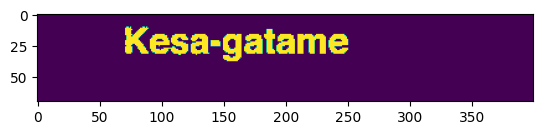

375


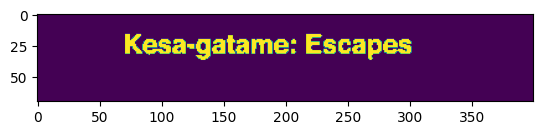

625


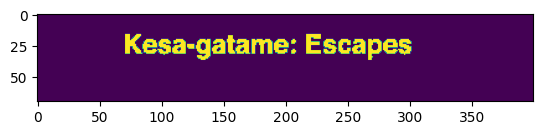

1000


In [393]:
for i in [25 * 15, 25 * 25, 25 * 40]:
    plt.imshow(frames[i])
    plt.show()
    print(i)

In [394]:
# write the frames to disk as a video
frame = frames[0]
writer = cv2.VideoWriter(
    "../data/tmp/frames.mp4",
    cv2.VideoWriter_fourcc(*"avc1"),
    120,
    (frame.shape[1], frame.shape[0]),
)
for i, frame in enumerate(frames):
    # grayscale to color
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    writer.write(frame)
writer.release()

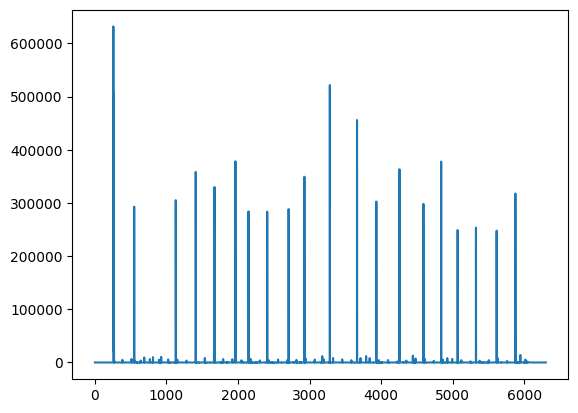

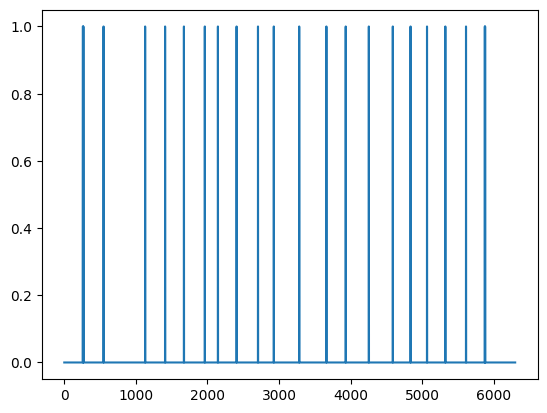

In [395]:
import pandas as pd

diffs = [0]
for i in range(1, len(frames)):
    # jaccard index
    a, b = frames[i], frames[i - 1]
    # score = np.sum(np.logical_and(a, b)) / (np.sum(np.logical_or(a, b) + 1e-6))
    score = np.sum(np.abs(a - b))
    diffs.append(score)
diffs = np.array(diffs)
# diffs = np.log(diffs + 1 + np.random.rand(len(diffs)))

scores = (diffs - np.mean(diffs)) / np.std(diffs)
# mad = np.median(np.abs(diffs - np.median(diffs)))
# scores = 0.6745 * np.abs(diffs - np.median(diffs))/ mad

# plt.plot(pd.Series(scores).rolling(5).mean())
plt.plot(diffs)
plt.show()

plt.plot(scores > 1.5)
plt.show()

In [396]:
idx = np.where(scores > 1.5)

start = np.where(diffs > 0)[0][0]
end = np.where(diffs > 0)[0][-1]
points = [start] + idx[0].tolist() + [end]
print(points)

# generate tuples of (start, end) index
intervals = []
for i in range(1, len(points)):
    a, b = points[i - 1], points[i]
    if b - a > 25:
        intervals.append((a, b - 1))
print(intervals)
print(len(intervals))

[258, 258, 259, 260, 261, 262, 263, 264, 266, 549, 1130, 1409, 1672, 1964, 2147, 2408, 2707, 2928, 3283, 3663, 3933, 4256, 4591, 4839, 5069, 5325, 5614, 5876, 5877, 5881, 6043]
[(266, 548), (549, 1129), (1130, 1408), (1409, 1671), (1672, 1963), (1964, 2146), (2147, 2407), (2408, 2706), (2707, 2927), (2928, 3282), (3283, 3662), (3663, 3932), (3933, 4255), (4256, 4590), (4591, 4838), (4839, 5068), (5069, 5324), (5325, 5613), (5614, 5875), (5881, 6042)]
20


In [398]:
# let's start saving files in chunks


def calculate_intervals(video):
    cap = cv2.VideoCapture(video.as_posix())
    frames = []
    for frame in tqdm(get_frames(cap)):
        subset = get_subset(frame)
        frames.append(subset)

    diffs = [0]
    for i in range(1, len(frames)):
        a, b = frames[i], frames[i - 1]
        score = np.sum(np.abs(a - b))
        diffs.append(score)
    diffs = np.array(diffs)
    scores = (diffs - np.mean(diffs)) / np.std(diffs)

    nonzero = np.where(diffs > 0)[0].tolist()
    points = [nonzero[0]] + np.where(scores > 1)[0].tolist() + [nonzero[-1]]
    intervals = []
    for i in range(1, len(points)):
        a, b = points[i - 1], points[i]
        if b - a > 25:
            intervals.append((a, b - 1))
    return intervals


# create the folder
def segment(video, dest_root, intervals):
    stem = video.stem.split()[-1].lower()
    dest_dir = dest_root / stem
    dest_dir.mkdir(parents=True, exist_ok=True)
    print(f"Saving clips to {dest_dir}")

    cap = cv2.VideoCapture(video.as_posix())
    writer = None
    interval_idx = 0
    for i, frame in tqdm(enumerate(get_frames(cap))):
        if interval_idx >= len(intervals):
            break
        if writer is None:
            filename = dest_dir / f"{stem}_{interval_idx:02d}.mp4"
            # print(f"Creating {filename}")
            writer = cv2.VideoWriter(
                filename.as_posix(),
                cv2.VideoWriter_fourcc(*"avc1"),
                25,
                (frame.shape[1], frame.shape[0]),
            )
        s, e = intervals[interval_idx]
        if i < s:
            continue
        if i > e:
            interval_idx += 1
            writer.release()
            writer = None
            continue
        writer.write(frame)


dest_root = Path("../data/clips")
video = [v for v in videos if "osaekomi-waza" in v.name.lower()][0]
intervals = calculate_intervals(video)
segment(video, dest_root, intervals)

6302it [00:07, 822.88it/s]


Saving clips to ../data/clips/osaekomi-waza


6044it [00:45, 131.76it/s]


In [399]:
dest_root = Path("../data/clips")
for video in tqdm(videos):
    intervals = calculate_intervals(video)
    segment(video, dest_root, intervals)

2180it [00:02, 777.34it/s]0<?, ?it/s]


Saving clips to ../data/clips/te-waza


1920it [00:11, 168.75it/s]
3273it [00:04, 814.60it/s]4<01:39, 14.26s/it]


Saving clips to ../data/clips/ashi-waza


3008it [00:21, 142.46it/s]
2375it [00:02, 806.49it/s]9<02:04, 20.69s/it]


Saving clips to ../data/clips/yoko-sutemi-waza


2110it [00:13, 155.74it/s]
6302it [00:08, 764.29it/s]5<01:33, 18.79s/it]


Saving clips to ../data/clips/osaekomi-waza


6044it [00:50, 118.53it/s]
1083it [00:01, 725.17it/s]5<02:19, 34.79s/it]


Saving clips to ../data/clips/ma-sutemi-waza


818it [00:04, 173.63it/s]
5314it [00:07, 691.44it/s]1<01:13, 24.49s/it]


Saving clips to ../data/clips/shime-waza


5056it [00:33, 150.02it/s]
1426it [00:01, 749.96it/s]3<01:00, 30.27s/it]


Saving clips to ../data/clips/koshi-waza


1161it [00:04, 261.77it/s]
2345it [00:03, 720.15it/s]9<00:22, 22.46s/it]


Saving clips to ../data/clips/kansetsu-waza


2094it [00:15, 139.31it/s]
100%|██████████| 8/8 [03:07<00:00, 23.46s/it]


In [400]:
! ls -lhR ../data/clips/

total 0
drwxr-xr-x  23 anthony  staff   736B Aug 19 19:29 ashi-waza
drwxr-xr-x  13 anthony  staff   416B Aug 19 19:32 kansetsu-waza
drwxr-xr-x   6 anthony  staff   192B Aug 19 19:31 koshi-waza
drwxr-xr-x   7 anthony  staff   224B Aug 19 19:31 ma-sutemi-waza
drwxr-xr-x  22 anthony  staff   704B Aug 19 19:31 osaekomi-waza
drwxr-xr-x  28 anthony  staff   896B Aug 19 19:31 shime-waza
drwxr-xr-x  18 anthony  staff   576B Aug 19 19:29 te-waza
drwxr-xr-x  18 anthony  staff   576B Aug 19 19:30 yoko-sutemi-waza

../data/clips//ashi-waza:
total 46400
-rw-r--r--  1 anthony  staff   967K Aug 19 19:29 ashi-waza_00.mp4
-rw-r--r--  1 anthony  staff   1.0M Aug 19 19:29 ashi-waza_01.mp4
-rw-r--r--  1 anthony  staff   925K Aug 19 19:29 ashi-waza_02.mp4
-rw-r--r--  1 anthony  staff   1.4M Aug 19 19:29 ashi-waza_03.mp4
-rw-r--r--  1 anthony  staff   1.3M Aug 19 19:29 ashi-waza_04.mp4
-rw-r--r--  1 anthony  staff   280K Aug 19 19:29 ashi-waza_05.mp4
-rw-r--r--  1 anthony  staff   1.2M Aug 19 19:29 ashi-waz